<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Examine-Lineup/Matchup-Stints" data-toc-modified-id="Examine-Lineup/Matchup-Stints-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examine Lineup/Matchup Stints</a></span></li><li><span><a href="#Time-Series-Study-of-Home-Court-Advantage-and-Game-Momentum" data-toc-modified-id="Time-Series-Study-of-Home-Court-Advantage-and-Game-Momentum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time Series Study of Home Court Advantage and Game Momentum</a></span></li><li><span><a href="#Analysis-of-Player-Trends-Over-Time" data-toc-modified-id="Analysis-of-Player-Trends-Over-Time-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis of Player Trends Over Time</a></span></li></ul></div>

In [1]:
import numpy as np
import time
import sys
import os
import pandas as pd
from functools import reduce
from operator import itemgetter
import itertools
import re
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import seaborn as sns
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
from scipy import signal
from scipy.stats import gaussian_kde

In [2]:
def window(size):
    return np.ones(size)/float(size)

def GetMatchupStarts(df):
    dfhead = df.groupby((df[['game', 'year', 'ht_lineup', 'vt_lineup']] != df[['game','year','ht_lineup','vt_lineup']].shift(1)).any(axis=1).cumsum()).head(1).reset_index(drop=True)
    return dfhead

def GetMatchupEnds(df):
    dftail = df.groupby((df[['game', 'year', 'ht_lineup', 'vt_lineup']] != df[['game','year','ht_lineup','vt_lineup']].shift(1)).any(axis=1).cumsum()).tail(1).reset_index(drop=True)
    return dftail


In [3]:
sns.set_style("whitegrid")

# Load Data

In [4]:
# Load and concatenate all play-by-play data over the last 3 full seasons
#df1 = pd.read_csv('NBA_PBP_Data_2016_2017.csv', index_col=0)
#df2 = pd.read_csv('NBA_PBP_Data_2017_2018.csv', index_col=0)
#df3 = pd.read_csv('NBA_PBP_Data_2018_2019.csv', index_col=0)
#df = pd.concat([df1, df2, df3], ignore_index=True)

df = pd.read_csv('../NBA_PBP_Data_PlusMinus.csv', index_col=0)

df.fillna('', inplace=True)

print(df)


/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


         year  game home_team vis_team  Q  time_sec  ht_score  vt_score  \
0        2017     1       CLE      NYK  1       0.0         0         0   
1        2017     1       CLE      NYK  1      20.0         0         2   
2        2017     1       CLE      NYK  1      34.0         0         2   
3        2017     1       CLE      NYK  1      37.0         0         2   
4        2017     1       CLE      NYK  1      44.0         0         2   
...       ...   ...       ...      ... ..       ...       ...       ...   
1675613  2019  1230       POR      SAC  4    2859.0       136       131   
1675614  2019  1230       POR      SAC  4    2859.0       136       131   
1675615  2019  1230       POR      SAC  4    2866.0       136       131   
1675616  2019  1230       POR      SAC  4    2869.0       136       131   
1675617  2019  1230       POR      SAC  4    2880.0       136       131   

         ht_margin  vt_margin  ... ht_3PTA vt_3PTA  ht_2PTM  vt_2PTM  ht_3PTM  \
0                0

In [5]:
# PBP data with lineup matchups with too few possessions
# (substitution-only plays, etc.) are removed for each game
min_num_poss = 3
df['total_poss'] = df.groupby(['game', 'year', 'ht_lineup', 'vt_lineup'], sort=False)['ht_stint_poss'].transform('count')
df = df[df['ht_stint_poss'] > min_num_poss]
#print(df)

# Get rows corresponding to start of new lineup matchup (+/- = 0)
dfs = GetMatchupStarts(df)
# Get rows corresponding to end of lineup matchup (final +/-)
dfe = GetMatchupEnds(df)
# Ensure each stint meets minimum possession requirement
dfs = dfs[dfe.ht_stint_poss > min_num_poss]
dfe = dfe[dfe.ht_stint_poss > min_num_poss]
print(dfs, dfe)

# Time average of all play-by-play data (over all games and lineups)
dfm = df.groupby(['time_sec'], as_index=False).mean()
#print(dfm)

# Time average of play-by-play data for each home,away lineup matchup
dfta = df.groupby(['time_sec', 'game', 'year', 'ht_lineup', 'vt_lineup'], as_index=False).mean()
#print(dfta)

# Play-by-play data grouped averaged by quarter
df_by_quarter = df.groupby(['Q'], as_index=False).mean()
#print(df_by_quarter)

# PBP data grouped by home and away teams for team-specific time analysis
dfht = df.groupby(['home_team', 'time_sec'], as_index=False).mean()
dfvt = df.groupby(['vis_team', 'time_sec'], as_index=False).mean()
#print(dfht, dfht.ht_margin)
#print(dfvt, dfvt.vt_margin)
#print(dfht.ht_margin-dfvt.vt_margin)
#print(dfht, dfvt)
#for name in np.unique(dfht.home_team.values): 
#    print(name)


       year  game home_team vis_team  Q  time_sec  ht_score  vt_score  \
0      2017     1       CLE      NYK  1      37.0         0         2   
1      2017     1       CLE      NYK  1     415.0        14        12   
2      2017     1       CLE      NYK  1     491.0        17        14   
3      2017     1       CLE      NYK  1     557.0        19        16   
4      2017     1       CLE      NYK  1     632.0        23        16   
...     ...   ...       ...      ... ..       ...       ...       ...   
98072  2019  1230       POR      SAC  4    2256.0       104       115   
98073  2019  1230       POR      SAC  4    2400.0       113       117   
98074  2019  1230       POR      SAC  4    2429.0       116       117   
98075  2019  1230       POR      SAC  4    2565.0       122       117   
98076  2019  1230       POR      SAC  4    2624.0       124       119   

       ht_margin  vt_margin  ... vt_3PTA ht_2PTM  vt_2PTM  ht_3PTM  vt_3PTM  \
0             -2          2  ...       0    

# Examine Lineup/Matchup Stints

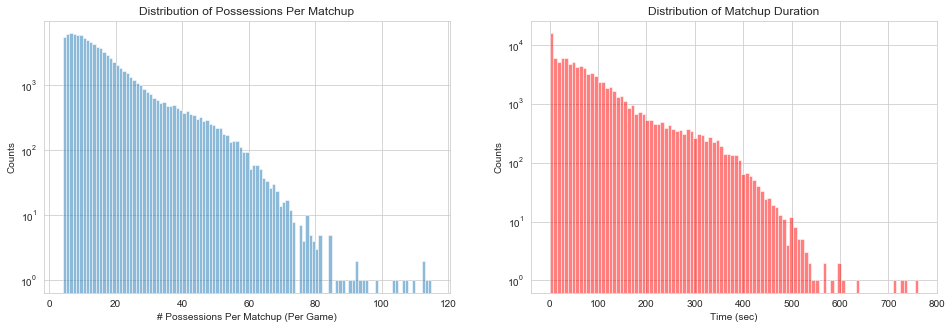

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

plt.axes(ax[0])
plt.title('Distribution of Possessions Per Matchup')
plt.xlabel('# Possessions Per Matchup (Per Game)')
plt.ylabel('Counts')
xmin = dfe['ht_stint_poss'].values.min()
xmax = dfe['ht_stint_poss'].values.max()
plt.hist(dfe['ht_stint_poss'], bins=(xmax-xmin), alpha=0.5)
plt.yscale('log')

plt.axes(ax[1])
plt.title('Distribution of Matchup Duration')
plt.xlabel('Time (sec)')
plt.ylabel('Counts')
plt.hist(dfe.time_sec-dfs.time_sec, bins=100, alpha=0.5, color='r')
plt.yscale('log')


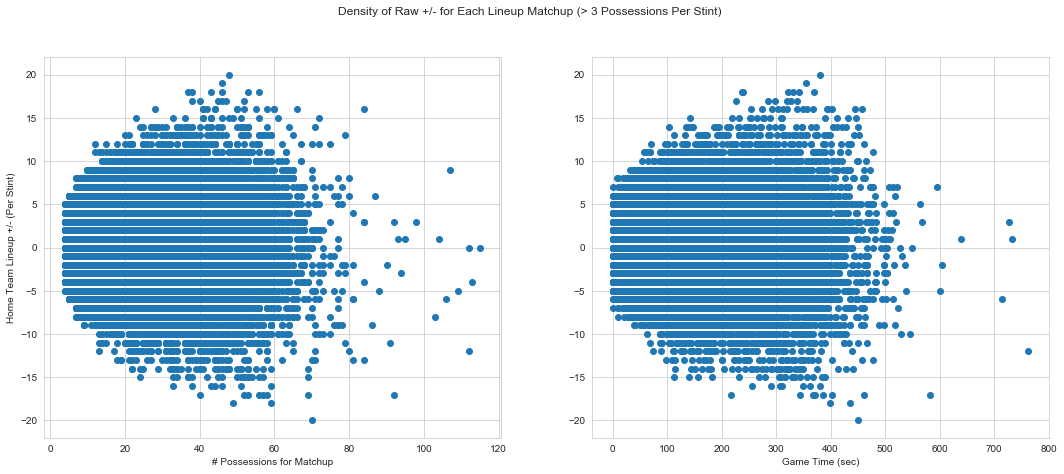

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))

plt.suptitle('Density of Raw +/- for Each Lineup Matchup (> 3 Possessions Per Stint)')

plt.axes(ax[0])
plt.xlabel('# Possessions for Matchup')
plt.ylabel('Home Team Lineup +/- (Per Stint)')
plt.scatter(dfe.ht_stint_poss, dfe.ht_stint_pm)
#xy = np.vstack([dfe['ht_stint_poss'].values, dfe['ht_stint_pm'].values])
#z = gaussian_kde(xy)(xy)
#plt.scatter(dfe.ht_stint_poss, dfe.ht_stint_pm, c=z, norm=matplotlib.colors.LogNorm())
#plt.colorbar()

plt.axes(ax[1])
plt.xlabel('Game Time (sec)')
plt.scatter(dfe.time_sec-dfs.time_sec, dfe.ht_stint_pm)
#xy = np.vstack([dfe.time_sec.values-dfs.time_sec.values, dfe.ht_stint_pm.values])
#z = gaussian_kde(xy)(xy)
#plt.scatter(dfe.time_sec-dfs.time_sec, dfe.ht_stint_pm, c=z, norm=matplotlib.colors.LogNorm())
#plt.colorbar()


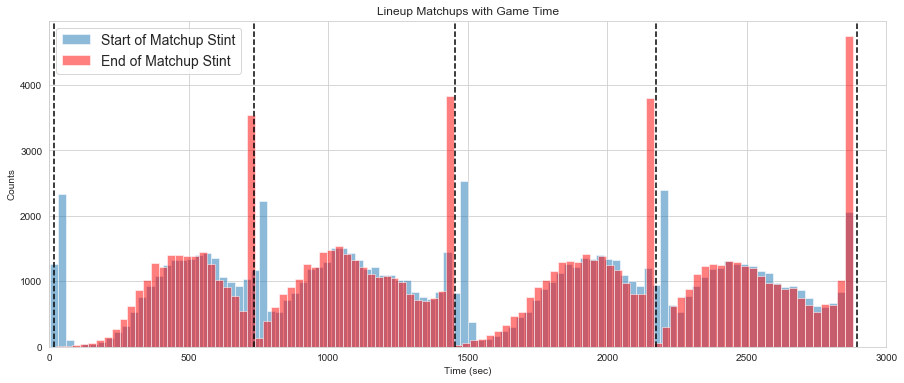

In [21]:
fig = plt.figure(figsize=(15,6))
plt.title('Lineup Matchups with Game Time')
plt.xlabel('Time (sec)')
plt.ylabel('Counts')
plt.hist(dfs.time_sec, bins=100, alpha=0.5, label='Start of Matchup Stint')
plt.hist(dfe.time_sec, bins=100, alpha=0.5, color='r', label='End of Matchup Stint')
for xc in [x+15 for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.xlim(0, 3000)
plt.legend(prop={'size': 14})


# Time Series Study of Home Court Advantage and Game Momentum

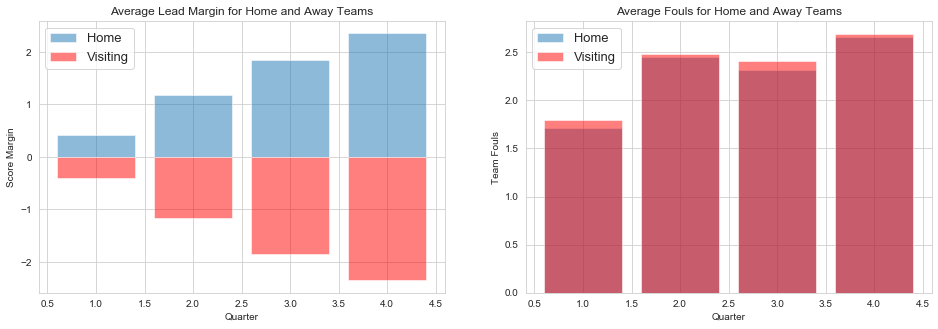

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

plt.axes(ax[0])
plt.title('Average Lead Margin for Home and Away Teams')
plt.bar(df_by_quarter['Q'], df_by_quarter['ht_margin'], alpha=0.5, label='Home')
plt.bar(df_by_quarter['Q'], df_by_quarter['vt_margin'], alpha=0.5, color='r', label='Visiting')
plt.xlabel('Quarter')
plt.ylabel('Score Margin')
plt.legend(prop={'size': 13})

plt.axes(ax[1])
plt.title('Average Fouls for Home and Away Teams')
plt.bar(df_by_quarter['Q'], df_by_quarter['ht_fouls'], alpha=0.5, label='Home')
plt.bar(df_by_quarter['Q'], df_by_quarter['vt_fouls'], alpha=0.5, color='r', label='Visiting')
plt.xlabel('Quarter')
plt.ylabel('Team Fouls')
plt.legend(prop={'size': 13})


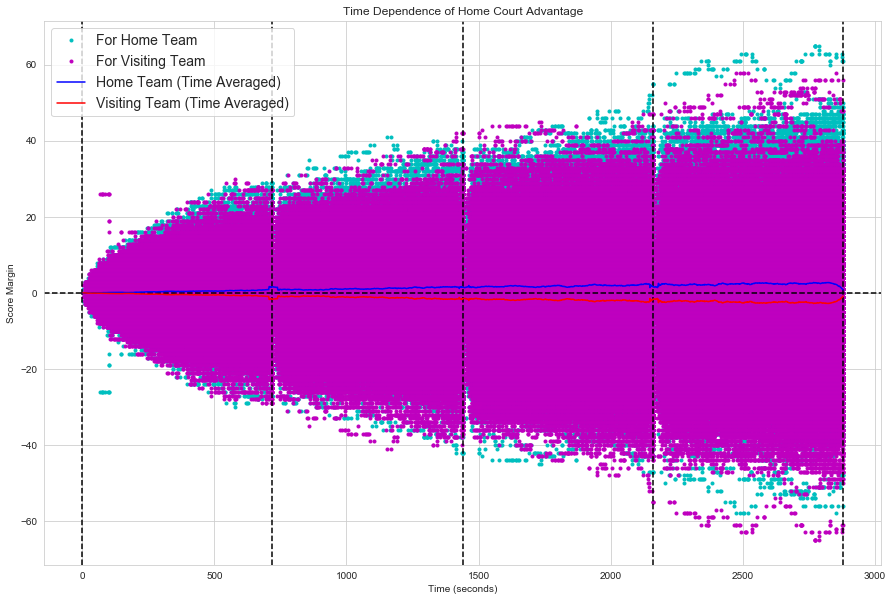

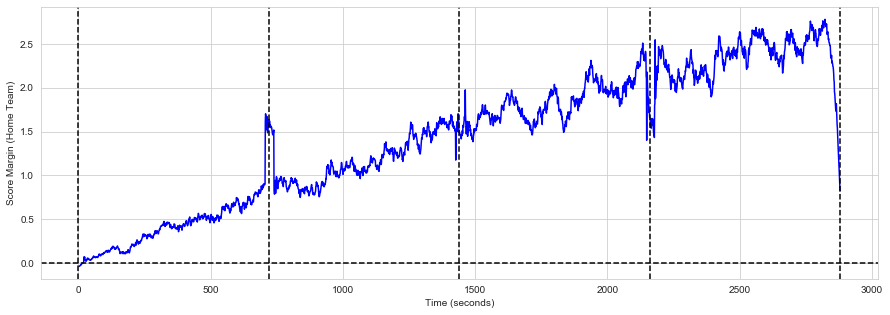

In [24]:
fig = plt.figure(figsize=(15,10))
plt.title('Time Dependence of Home Court Advantage')
plt.xlabel('Time (seconds)')
plt.ylabel('Score Margin')
plt.plot(df.time_sec, df.ht_margin.values.astype(float), 'c.', label='For Home Team')
plt.plot(df.time_sec, df.vt_margin.values.astype(float), 'm.', label='For Visiting Team')
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.axhline(0, linestyle='--', c='k')
#plt.plot(dfm.time_sec, dfm.ht_margin.values.astype(float),'b-', label='Home Team (Time Averaged)')
#plt.plot(dfm.time_sec, dfm.vt_margin.values.astype(float),'r-', label='Visiting Team (Time Averaged)')
plt.plot(dfm.time_sec, np.convolve(dfm.ht_margin.values.astype(float), window(30),'same'),'b-', label='Home Team (Time Averaged)')
plt.plot(dfm.time_sec, np.convolve(dfm.vt_margin.values.astype(float), window(30),'same'),'r-', label='Visiting Team (Time Averaged)')
plt.legend(loc='upper left', prop={'size': 14})

fig = plt.figure(figsize=(15,5))
plt.xlabel('Time (seconds)')
plt.ylabel('Score Margin (Home Team)')
plt.plot(dfm.time_sec, np.convolve(dfm.ht_margin.values.astype(float), window(30),'same'),'b-')
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.axhline(0, linestyle='--', c='k')


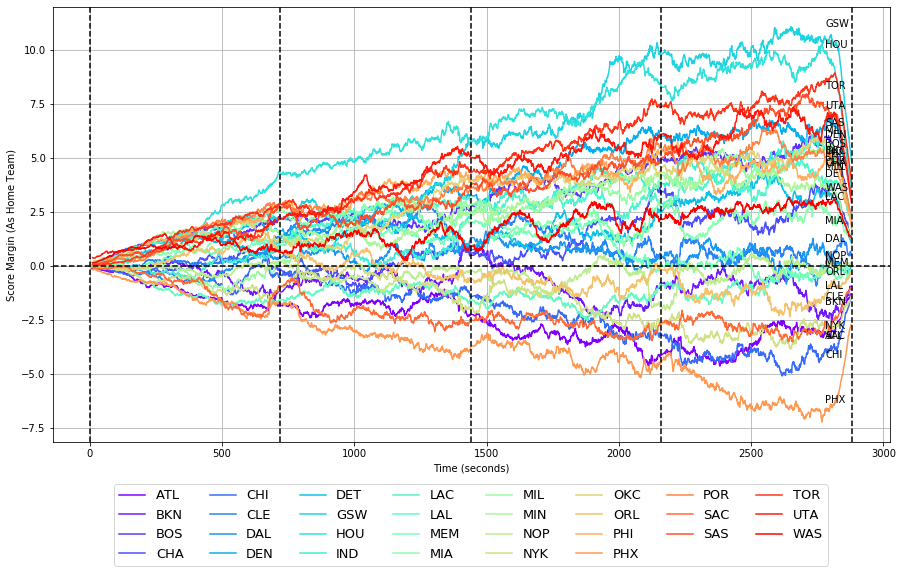

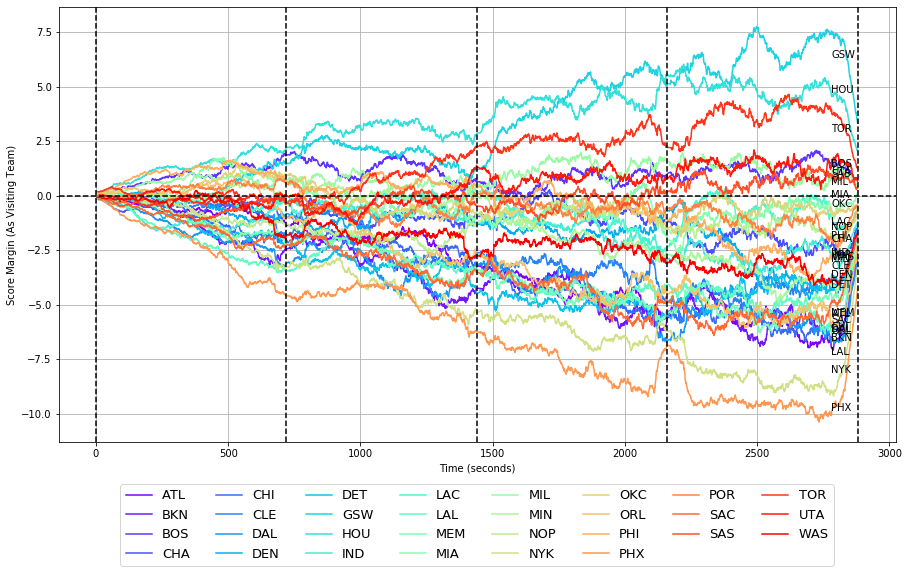

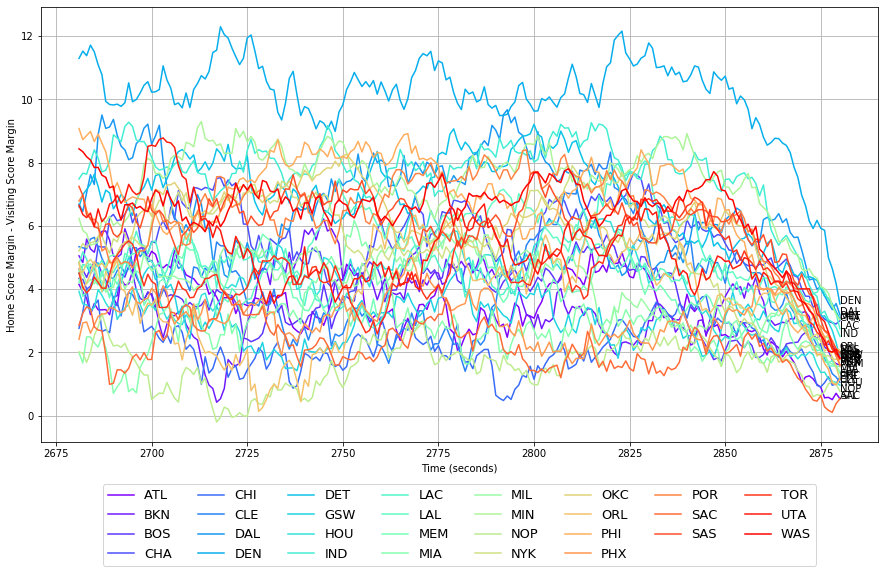

In [63]:
fig = plt.figure(figsize=(15,8))
plt.xlabel('Time (seconds)')
plt.ylabel('Score Margin (As Home Team)')
color=iter(cm.rainbow(np.linspace(0,1,len(np.unique(dfht.home_team.values)))))
for i,name in enumerate(np.unique(dfht.home_team.values)):
    c=next(color)
    plt.plot(dfht[dfht.home_team == name].time_sec, np.convolve(dfht[dfht.home_team == name].ht_margin.values.astype(float), window(100),'same'),'-', c=c, label=name)
    plt.annotate(name, (dfht[dfht.home_team == name].time_sec.values[-100], np.convolve(dfht[dfht.home_team == name].ht_margin.values.astype(float), window(30),'same')[-100]))
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.axhline(0, linestyle='--', c='k')
plt.grid()
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.3), prop={'size': 13})


fig = plt.figure(figsize=(15,8))
plt.xlabel('Time (seconds)')
plt.ylabel('Score Margin (As Visiting Team)')
color=iter(cm.rainbow(np.linspace(0,1,len(np.unique(dfvt.vis_team.values)))))
for i,name in enumerate(np.unique(dfvt.vis_team.values)):
    c=next(color)
    plt.plot(dfvt[dfvt.vis_team == name].time_sec, np.convolve(dfvt[dfvt.vis_team == name].vt_margin.values.astype(float), window(100),'same'),'-', c=c, label=name)
    plt.annotate(name, (dfvt[dfvt.vis_team == name].time_sec.values[-100], np.convolve(dfvt[dfvt.vis_team == name].vt_margin.values.astype(float), window(30),'same')[-100]))
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.axhline(0, linestyle='--', c='k')
plt.grid()
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.3), prop={'size': 13})


fig = plt.figure(figsize=(15,8))
plt.xlabel('Time (seconds)')
plt.ylabel('Home Score Margin - Visiting Score Margin')
color=iter(cm.rainbow(np.linspace(0,1,len(np.unique(dfvt.vis_team.values)))))
conv_margins = []
for i,name in enumerate(np.unique(dfvt.vis_team.values)):
    #print(name)
    c=next(color)
    conv_home_margin = np.convolve(dfht[dfht.home_team == name].ht_margin.values.astype(float), window(30),'same')
    conv_vis_margin = np.convolve(dfvt[dfvt.vis_team == name].vt_margin.values.astype(float), window(30),'same')
    resampled_vis_margin = signal.resample(conv_vis_margin, len(conv_home_margin))
    conv_margin = conv_home_margin - resampled_vis_margin
    #resampled_time = signal.resample(dfvt[dfvt.vis_team == name].time_sec.values.astype(float), len(conv_margin))
    plt.plot(dfht[dfht.home_team == name].time_sec[-200:], conv_margin[-200:],'-', c=c, label=name)
    plt.annotate(name, (dfht[dfht.home_team == name].time_sec.values[-1], conv_margin[-1]))
    conv_margins.append(conv_margin[-1])
#for xc in [x for x in np.arange(2881) if x%720 == 0]:
#    plt.axvline(xc, linestyle='--', c='k')
#plt.axhline(0, linestyle='--', c='k')
plt.grid()
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.3), prop={'size': 13})


In [64]:
sorted_teams = np.unique(dfvt.vis_team.values)
sorted_margins = [x for _,x in sorted(zip(conv_margins, sorted_teams), reverse=True)]
#print(sorted_margins)
print('Teams Ranked by Relative Home Court Advantage:')
for i,name in enumerate(sorted_margins):
    print(str(i+1)+'.', name, ':\t', sorted(conv_margins, reverse=True)[i], 'pts')
    

Teams Ranked by Relative Home Court Advantage:
1. DEN :	 3.526877021639071 pts
2. DAL :	 3.1868569988378903 pts
3. DET :	 3.059514168427155 pts
4. MIN :	 3.028585689407405 pts
5. CHA :	 3.002961144405835 pts
6. LAC :	 2.7439545372900236 pts
7. IND :	 2.506493195579091 pts
8. ORL :	 2.0673280451418408 pts
9. MIL :	 2.018543628448541 pts
10. SAS :	 1.982223332373676 pts
11. TOR :	 1.8409630655947546 pts
12. GSW :	 1.8372858460505825 pts
13. BOS :	 1.81767743546399 pts
14. UTA :	 1.8016381128351233 pts
15. WAS :	 1.8012692037732565 pts
16. NYK :	 1.7696979150736833 pts
17. POR :	 1.603895500425743 pts
18. BKN :	 1.5980529861211372 pts
19. PHX :	 1.5691585161520902 pts
20. MEM :	 1.5488788462616594 pts
21. MIA :	 1.3706770024395967 pts
22. LAL :	 1.3435930628637425 pts
23. CHI :	 1.2131220237186946 pts
24. PHI :	 1.1628557684323149 pts
25. OKC :	 1.1483175595199482 pts
26. CLE :	 1.04848181383723 pts
27. HOU :	 0.9568016862742104 pts
28. NOP :	 0.7620353977220823 pts
29. SAC :	 0.528948201

# Analysis of Player Trends Over Time

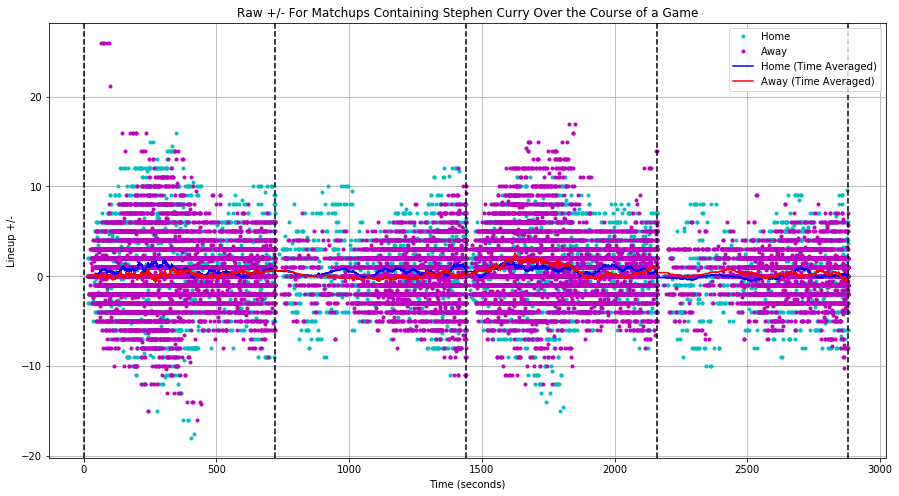

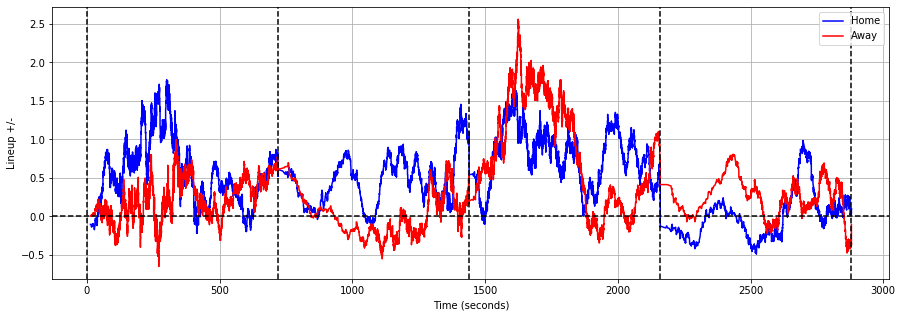

In [65]:
fig = plt.figure(figsize=(15,8))

plt.title('Raw +/- For Matchups Containing Stephen Curry Over the Course of a Game')
plt.xlabel('Time (seconds)')
plt.ylabel('Lineup +/-')
dftas_ht = dfta[dfta.ht_lineup.str.contains('Stephen Curry')].time_sec.values
dftas_hpm = dfta[dfta.ht_lineup.str.contains('Stephen Curry')].ht_stint_pm.values
dftas_vt = dfta[dfta.vt_lineup.str.contains('Stephen Curry')].time_sec.values
dftas_vpm = dfta[dfta.vt_lineup.str.contains('Stephen Curry')].vt_stint_pm.values

plt.plot(dftas_ht, dftas_hpm, 'c.', label='Home')
plt.plot(dftas_vt, dftas_vpm, 'm.', label='Away')
#dftas_ht, dftas_hpm, dftas_vt, dftas_vpm = PlayerPlusMinus(dfta, 'Stephen Curry')
#dftas_t = np.concatenate((dfta[dfta.ht_lineup.str.contains('Stephen Curry')].time_sec.values, dfta[dfta.vt_lineup.str.contains('Stephen Curry')].time_sec.values), axis=None)
#dftas_pm = np.concatenate((dfta[dfta.ht_lineup.str.contains('Stephen Curry')].ht_stint_pm.values, dfta[dfta.vt_lineup.str.contains('Stephen Curry')].vt_stint_pm.values), axis=None)
plt.plot(dftas_ht, np.convolve(dftas_hpm, window(200), 'same'), 'b-', label='Home (Time Averaged)')
plt.plot(dftas_vt, np.convolve(dftas_vpm, window(200), 'same'), 'r-', label='Away (Time Averaged)')
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.grid()
#plt.ylim(-1.3, 2.7)
plt.legend()

fig = plt.figure(figsize=(15,5))
plt.xlabel('Time (seconds)')
plt.ylabel('Lineup +/-')
plt.plot(dftas_ht, np.convolve(dftas_hpm, window(200), 'same'), 'b-', label='Home')
plt.plot(dftas_vt, np.convolve(dftas_vpm, window(200), 'same'), 'r-', label='Away')
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
plt.axhline(0, linestyle='--', c='k')
plt.grid()
plt.legend()



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


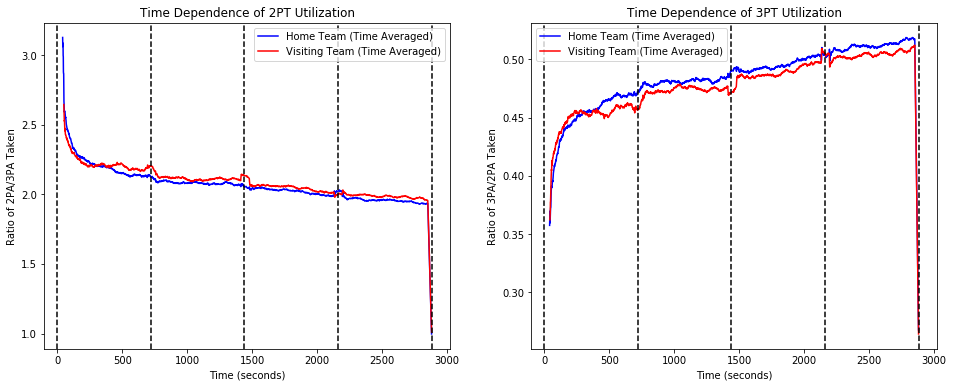

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

plt.axes(ax[0])
plt.title('Time Dependence of 2PT Utilization')
plt.xlabel('Time (seconds)')
plt.ylabel('Ratio of 2PA/3PA Taken')
plt.plot(dfm.time_sec, np.convolve(dfm.ht_2PTA.values.astype(float)/dfm.ht_3PTA.values.astype(float), window(60),'same'),'b-', label='Home Team (Time Averaged)')
plt.plot(dfm.time_sec, np.convolve(dfm.vt_2PTA.values.astype(float)/dfm.vt_3PTA.values.astype(float), window(60),'same'),'r-', label='Visiting Team (Time Averaged)')
plt.legend()
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
    
plt.axes(ax[1])
plt.title('Time Dependence of 3PT Utilization')
plt.xlabel('Time (seconds)')
plt.ylabel('Ratio of 3PA/2PA Taken')
#plt.plot(df.time_sec, df.ht_3PTA.values.astype(float)/df.ht_2PTA.values.astype(float), 'c.', label='Home Team')
#plt.plot(df.time_sec, df.vt_3PTA.values.astype(float)/df.vt_2PTA.values.astype(float), 'm.', label='Visiting Team')
plt.plot(dfm.time_sec, np.convolve(dfm.ht_3PTA.values.astype(float)/dfm.ht_2PTA.values.astype(float), window(60),'same'),'b-', label='Home Team (Time Averaged)')
plt.plot(dfm.time_sec, np.convolve(dfm.vt_3PTA.values.astype(float)/dfm.vt_2PTA.values.astype(float), window(60),'same'),'r-', label='Visiting Team (Time Averaged)')
plt.legend()
for xc in [x for x in np.arange(2881) if x%720 == 0]:
    plt.axvline(xc, linestyle='--', c='k')
